# Software quality checks

# Haque, Çetiner, Gunawardea 2024. _Anomalous behavior of the Steinberg signature for detecting departure from thermodynamic equilibrium._

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm import tqdm

from steinberg_utils_3vertex import *
from general_graph_utils_main import *

In [12]:
# plot formatting
plt.rc("text", usetex=False) # renders LaTeX more quickly
plt.rc("font", family = "serif",size=14) # font specifications
plt.rc("figure",figsize=(10,8)) # figure size
%config InlineBackend.figure_format = 'retina' # retina-display quality

### Quality checks:

1. How can we systematically determine the tau range without taking forever?
2. Are the autocorrelation functions always monotonically decreasing and are they separate?
3. Do the indefinite integrals we compute converge?

### Developing a systematic range for $\tau$

We need to capture the entire decay period of the asymmetric autocorrelation functions in order to accurately calculate the area between them (i.e. the Steinberg signature). Thus, it is important to define the $\tau$ array with a large enough maximal $\tau$. However, choosing a maximal $\tau$ that is too large can make calculating the asymmetric autocorrelation functions much more computationally expensive, and thus our estimations of the Steinberg signature become intractible. 

To systematically determine an optimal value of $\tau$, we consider the **mixing time** $\tau_{mix}$ for continuous time Markov processes. The mixing time is the time it takes for the Markov process to get "close" to its steady state. It is defined as 

$$\tau_{mix} = \text{inf} \{ t > 0 : \text{sup}_x || P_t(x,.) - \pi||_{TV} \leq \epsilon \} \, ,$$

where $P_t = \text{exp}(Lt)$ is the transition kernel, and $||.||_{TV}$ is the total variation distance. (Reference: Levin, Peres, and Wilmer. Markov Chains and Mixing Times, Chapter 20, Equation 20.9, https://pages.uoregon.edu/dlevin/MARKOV/mcmt2e.pdf).

In practice, people use the spectral gap $\lambda_1$ of $−L$, defined as the smallest nonzero eigenvalue of $−L$ (assuming the process is irreducible). This governs the exponential rate of convergence to stationarity. The relaxation time is then:

$$\tau_{relax} = 1/\lambda_1\, .$$

(Reference: Aldous and Fill, Reversible Markov Chains and Random Walks on Graphs. Chapter 3, Equations 3.38-3.39, https://www.stat.berkeley.edu/~aldous/RWG/book.pdf)

Here, we use the relaxation time $\tau_{relax}$ to obtain an optimal maximal $\tau$ value and ensure that our asymmetric autocorrelation functions are computed in their entirety. We have verified that the correct formula to use for continuous time Markov processes is the inverse of the spectral gap, which is the first nontrivial eigenvalue. To make sure our $\tau_{max}$ is indeed large enough, we set $\tau_{max} = 2 \tau_{relax} = 2 / \lambda_1$.

In [141]:
def define_tau_range(L, max_points=500, cap_factor=10.0):
    # infer the slowest rate
    eigs = np.real(np.linalg.eigvals(-L))
    eigs.sort()
    lambda_1 = eigs[1]
    
    # set upper bound but don’t let it explode
    tau_max = min(cap_factor/lambda_1, 100.0)   # never longer than 100 time-units
    tau = np.linspace(0.01, tau_max, num=max_points)
    return tau, tau_max

In [145]:
signal = [3, 5, 7]
alpha = 1
beta = 3

# High-precision parameter baseline
base_params = [0.68963912, 0.21372054, 0.00839508, 3.92541264, 4.91045962, 0.03214169]

# Choose which significant figures to test
sig_fig_list = [7, 5, 4, 3, 2]

# Dictionary to store results
autocorr_data = {}

for sig_figs in sig_fig_list:
    # Round each parameter to the desired number of sig figs
    def round_sig(x, sig):
        if x == 0:
            return 0
        return round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)

    params = [round_sig(p, sig_figs) for p in base_params]

    # Run your autocorrelation pipeline
    L = Laplacian_K(params)
    tau, tau_max = define_tau_range(L, max_points=500, cap_factor=10.0)
    pi = steady_state_MTT_K(params)
    a_13, a_31 = asymmetric_autocorrelation(signal, L, tau, pi, alpha, beta)
    delta_a = a_13 - a_31
    area = numerical_area(a_13, a_31)

    # Store results in dictionary
    autocorr_data[sig_figs] = {
        'params': params,
        'tau': tau,
        'a_13': a_13,
        'a_31': a_31,
        'delta': delta_a,
        'area': area
    }

    print(f"Sig figs: {sig_figs}, Area = {area:.6f}")

Sig figs: 7, Area = 422.015261
Sig figs: 5, Area = 422.014340
Sig figs: 4, Area = 422.014220
Sig figs: 3, Area = 422.216127
Sig figs: 2, Area = 417.154774


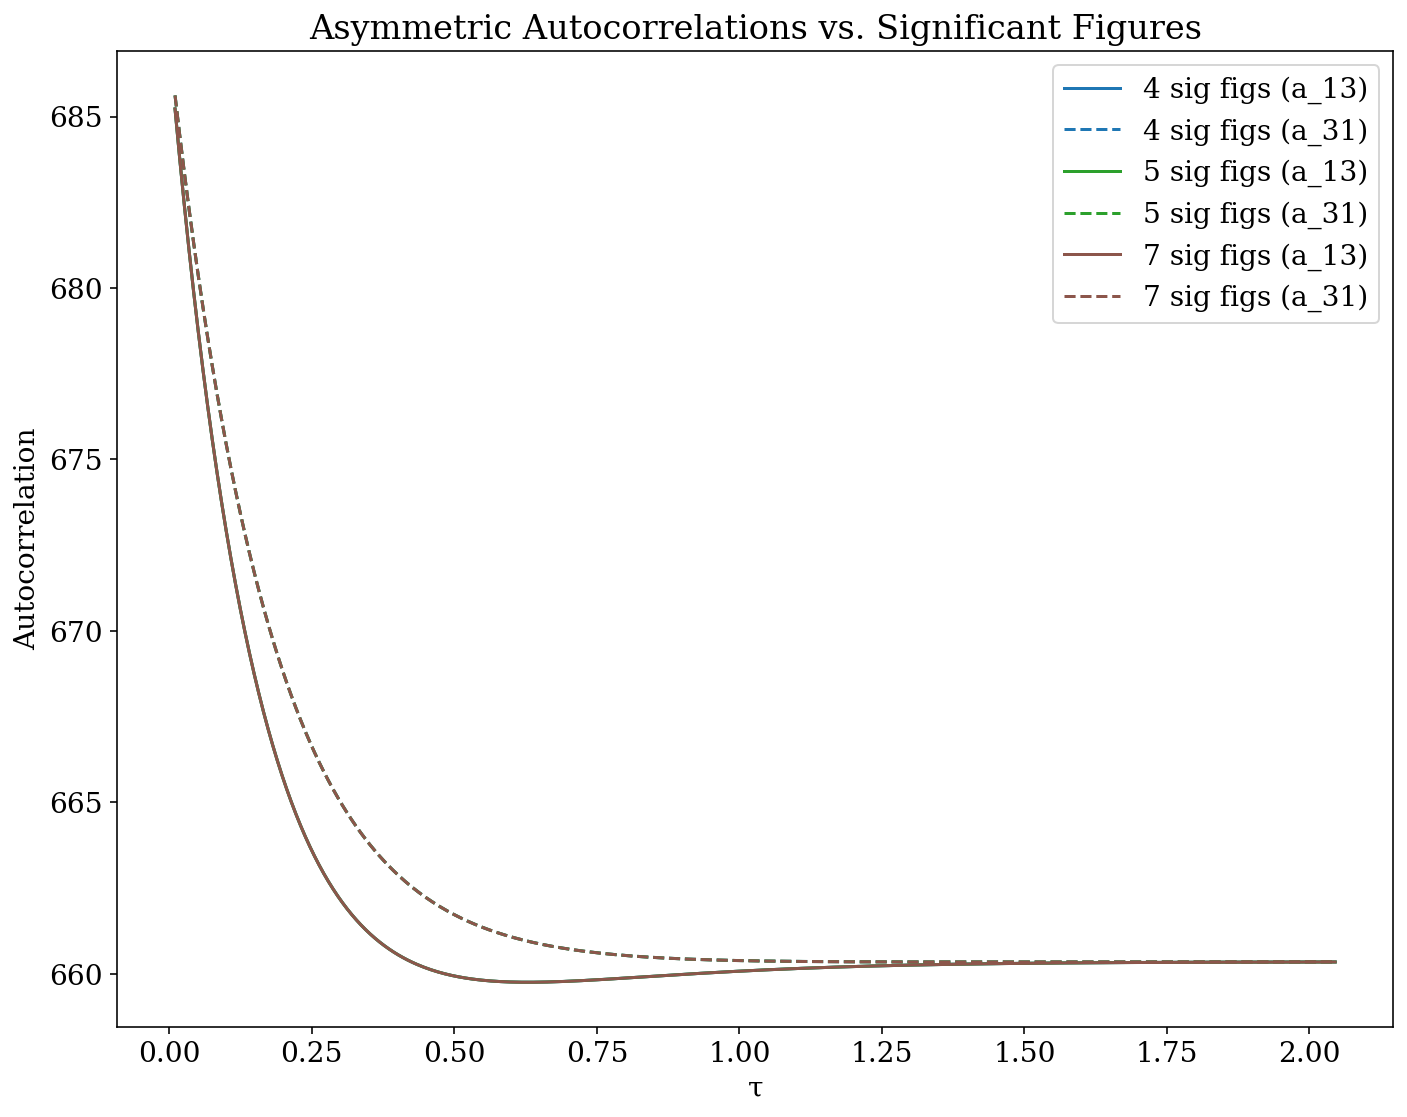

In [162]:
plt.figure(figsize=(10, 8))

sig_fig_list = sorted(autocorr_data.keys())  # Ensure consistent order
cmap = cm.get_cmap('tab10', len(sig_fig_list))

for idx, sig in enumerate(sig_fig_list[2:]):
    color = cmap(idx)  # Get color from colormap
    data = autocorr_data[sig]
    
    # Plot a_13 (solid)
    plt.plot(data['tau'], data['a_13'], color=color, linestyle='-', label=f"{sig} sig figs (a_13)")
    
    # Plot a_31 (dashed, same color)
    plt.plot(data['tau'], data['a_31'], color=color, linestyle='--', label=f"{sig} sig figs (a_31)")

plt.xlabel("τ")
plt.ylabel("Autocorrelation")
plt.title("Asymmetric Autocorrelations vs. Significant Figures")
plt.legend()
plt.tight_layout()
plt.show()

### Number of signifiant figures necessary for autocorrelation function calculation

### Test for monotonicity

Are autocorrelation functions $\mathcal{A}^{\alpha,\beta}(\tau)$ always monotonic decreasing? 

In [86]:
# Function to check array is monotonic
def check(arr):
    N = len(arr)
    inc = True
    dec = True
     
    # Loop to check if array is increasing
    for i in range(0, N-1):
       
        # To check if array is not increasing
        if arr[i] > arr[i+1]:
            inc = False
 
    # Loop to check if array is decreasing
    for i in range(0, N-1):
       
       # To check if array is not decreasing
        if arr[i] < arr[i+1]:
            dec = False
 
    # Pick one whether inc or dec
    return inc or dec

print("Is Monotonic ?: ", check([7, 5, 3, 1]))
print("Is Monotonic ?: ", check([4, 0, 3, 1]))
print("Is Monotonic ?: ", check([5, 4, 3]))

Is Monotonic ?:  True
Is Monotonic ?:  False
Is Monotonic ?:  True


In [87]:
def check_monotonic(array):
	return (
		# First check for decreasing order sequence...
		all(element <= array[index - 1] for index, element in enumerate(array) if index > 0) or
		# Then check for increasing order sequence...
		all(element >= array[index - 1] for index, element in enumerate(array) if index > 0)
	)

print("Is Monotonic ?: ", check_monotonic([7, 5, 3, 1]))
print("Is Monotonic ?: ", check_monotonic([4, 0, 3, 1]))
print("Is Monotonic ?: ", check_monotonic([5, 4, 3]))

Is Monotonic ?:  True
Is Monotonic ?:  False
Is Monotonic ?:  True


In [88]:
def check_monotonic_dec(array):
    
    N = len(array)
    inc = True
    dec = True
    
    # loop to check if array is increasing
    for i in range(0, N-1):
        if array[i] > array[i+1]:
            return True
        elif array[i] < array[i+1]:
            return True
        else:
            return False

print("Is Monotonic ?: ", check_monotonic_dec([7, 5, 3, 1]))
print("Is Monotonic ?: ", check_monotonic_dec([4, 0, 3, 1]))
print("Is Monotonic ?: ", check_monotonic_dec([5, 4, 3]))

Is Monotonic ?:  True
Is Monotonic ?:  True
Is Monotonic ?:  True


In [89]:
signal = [3, 5, 7]
alpha = 1
beta = 3
tau = np.around(np.arange(0.01,4,step=.01), decimals = 2)

params = random_parameters()
L = Laplacian_K(params)
pi = steady_state_MTT_K(params)
a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha,beta)

In [145]:
tau = np.around(np.arange(0.01,.03,step=.000001), decimals = 2)
a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha,beta)

In [146]:
print(check(a_13))
print(check_monotonic(a_13))

print(check(a_31))
print(check_monotonic(a_31))

True
True
True
True


In [147]:
a_13

array([1497.22584644, 1497.22584644, 1497.22584644, ..., 1496.96027487,
       1496.96027487, 1496.96027487], dtype=float128)

In [148]:
a_31

array([1497.21066769, 1497.21066769, 1497.21066769, ..., 1496.96027484,
       1496.96027484, 1496.96027484], dtype=float128)

In [149]:
numerical_area(a_13,a_31)

76.09912808994158695

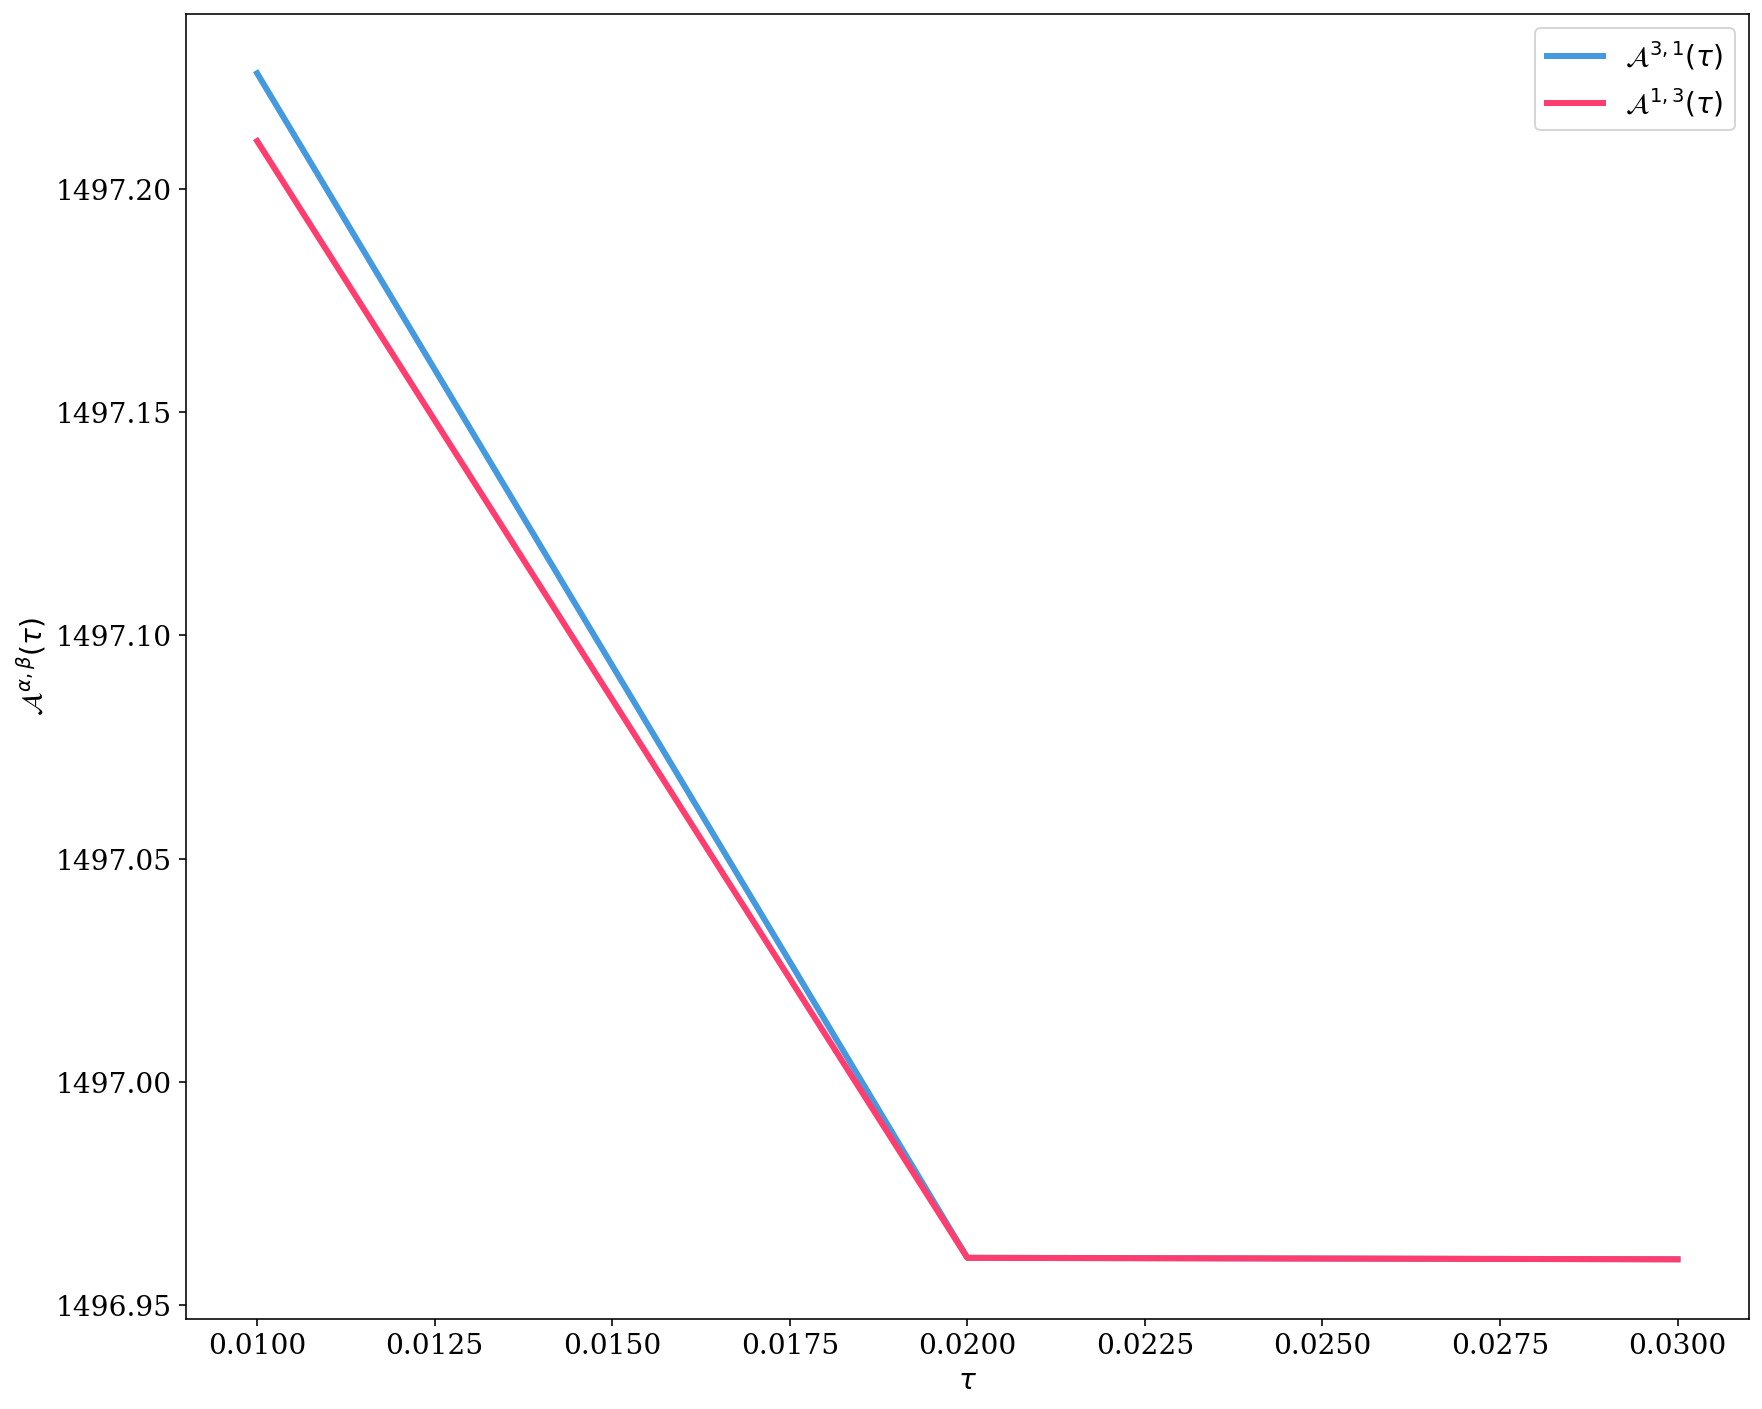

In [150]:
fig = plt.figure()
plt.plot(tau,a_13,label=r'$\mathcal{A}^{3,1}(\tau)$',linewidth=3, c= '#4599DF')
plt.plot(tau,a_31,label=r'$\mathcal{A}^{1,3}(\tau)$',linewidth=3,color='#FF3D6E')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathcal{A}^{\alpha,\beta}(\tau)$")
plt.legend()
plt.show()

### Test for separation

1. Does one of the curves $\mathcal{A}^{\alpha,\beta}(\tau)$ or $\mathcal{A}^{\beta,\alpha}(\tau)$ always lie above the other, or do the two curves cross for positive values of $\tau$? 
2. Does this separation of the two curves always occur for all sets of parameter values? 

Initialize a system.

In [4]:
params = random_parameters()

In [5]:
L = Laplacian_K(params)

In [6]:
pi = steady_state_MTT_K(params)

In [7]:
signal = [3, 5, 7]
alpha = 1
beta = 3
tau = np.around(np.arange(0.01,40.01,step=.01), decimals = 2)

In [8]:
a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha,beta)

In [26]:
index_a13 = np.array([])
index_a31 = np.array([])

In [27]:
for i in range(len(tau)):
    if np.round(a_13[i],10) > np.round(a_31[i],10):
        index_a13 = np.append(index_a13, i)
    elif np.round(a_13[i],10) < np.round(a_31[i],10):
        index_a31 = np.append(index_a31, i)
    elif np.round(a_13[i],10) == np.round(a_31[i],10):
        continue

In [28]:
index_a13

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 2.427e+03, 2.480e+03,
       2.487e+03])

In [29]:
index_a31

array([], dtype=float64)

The discrepancy for these specific points most likely comes from numerical precision error in the calculation of a_13 and a_31. We could try to round the values in the array, but how do we decide the cut-off?

In [32]:
def test_separation(a_13,a_31,tau):
    index_a13 = np.array([])
    index_a31 = np.array([])
    
    for i in range(len(tau)):
        if np.round(a_13[i],10) > np.round(a_31[i],10):
            index_a13 = np.append(index_a13, i)
        elif np.round(a_13[i],10) < np.round(a_31[i],10):
            index_a31 = np.append(index_a31, i)
        elif np.round(a_13[i],10) == np.round(a_31[i],10):
            continue
    
    return index_a13, index_a31

Are both steady state functions equivalent?

In [3]:
params = random_parameters()

In [4]:
L = Laplacian_K(params)

In [5]:
pi = steady_state_MTT_K(params)
print(pi)
print(pi.ndim)
print(np.diag(pi))

[0.03706932 0.14074326 0.82218742]
1
[[0.03706932 0.         0.        ]
 [0.         0.14074326 0.        ]
 [0.         0.         0.82218742]]


In [6]:
pi_all = steady_state_spectrum(L)
print(pi_all)
print(pi_all.ndim)
print(np.diag(pi_all))

[0.03706932 0.14074326 0.82218742]
1
[[0.03706932 0.         0.        ]
 [0.         0.14074326 0.        ]
 [0.         0.         0.82218742]]


In [7]:
def steady_state_spectrum(L):
    """
    Calculates the steady-state distribution for the any linear framework graph by computing the eigenvector associated with eigenvalue 0.
    
    Parameters
    ----------
    L : num_nodes x num_nodes array
        the Laplacian matrix of the graph G
    
    Returns
    -------
    pi : 1D array
         the steady state distribution for a 3-vertex graph K.
    
    """
    
    eigvals, eigvecs = scipy.linalg.eig(L)
    pi = [eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)]
    
    return pi

In [8]:
pi

array([0.03706932, 0.14074326, 0.82218742], dtype=float128)

In [9]:
pi_all

array([0.03706932, 0.14074326, 0.82218742], dtype=float128)

In [10]:
pi.ndim

1

In [11]:
pi_all.ndim

1

What is the largest possible area difference we can get?

In [12]:
# choosing a tau range large enough such that the entire decay is captured for as many sets of autocorrelation functions as possible
tau = np.around(np.arange(0.01,40.0,step=.01), decimals = 2)
signal = [3, 5, 7]
alpha = 1
beta = 3

true_params = np.array([])

new_area = 0
crowned_area = 0

for i in tqdm(range(100)):
    # randomly sample new parameters on K
    params = random_parameters()
    
    # calculate the autocorrelation functions
    L = Laplacian_K(params)
    pi = steady_state_MTT_K(params)
    a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha,beta)
    
    new_area = numerical_area(a_13,a_31)
    
    if new_area > crowned_area:
        true_params = params
        crowned_area = new_area

100%|█████████████████████████████████████████| 100/100 [03:27<00:00,  2.07s/it]


In [19]:
crowned_area

3269.2927552356802607

In [20]:
true_params

array([0.32161742, 0.3968768 , 0.00260506, 0.01338035, 0.02071359,
       0.00607068], dtype=float128)

1. Are autocorrelation functions $\mathcal{A}^{\alpha,\beta}(\tau)$ always monotonic decreasing? 
2. Does one of the curves $\mathcal{A}^{\alpha,\beta}(\tau)$ or $\mathcal{A}^{\beta,\alpha}(\tau)$ always lie above the other, or do the two curves cross for positive values of $\tau$? 
3. Does this separation of the two curves always occur for all sets of parameter values? 

In [31]:
params = random_parameters()
print(params)

[1.03928414e+01 5.82841470e-02 5.16352292e+01 2.79212497e+01
 1.13780955e-01 5.92138344e+02]


In [32]:
L = Laplacian_K(params)
L

array([[-1.05066224e+01,  5.82841470e-02,  5.92138344e+02],
       [ 1.03928414e+01, -5.16935133e+01,  2.79212497e+01],
       [ 1.13780955e-01,  5.16352292e+01, -6.20059594e+02]],
      dtype=float128)

In [33]:
pi = steady_state_MTT(params)
pi

array([0.81410504, 0.17146674, 0.01442822], dtype=float128)

In [34]:
# double check SS function works
pi_2 = steady_state_spectrum(L)
pi_2

array([[0.81410504],
       [0.17146674],
       [0.01442822]])

In [35]:
signal = [3, 5, 7]
alpha = 1
beta = 3

In [36]:
tau = np.around(np.arange(0.01,40.01,step=.01), decimals = 2)

In [37]:
a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha,beta)

In [38]:
sum(a_13.round(5) >= a_31.round(5))

4000

In [39]:
sum(a_31.round(5) > a_13.round(5))

0

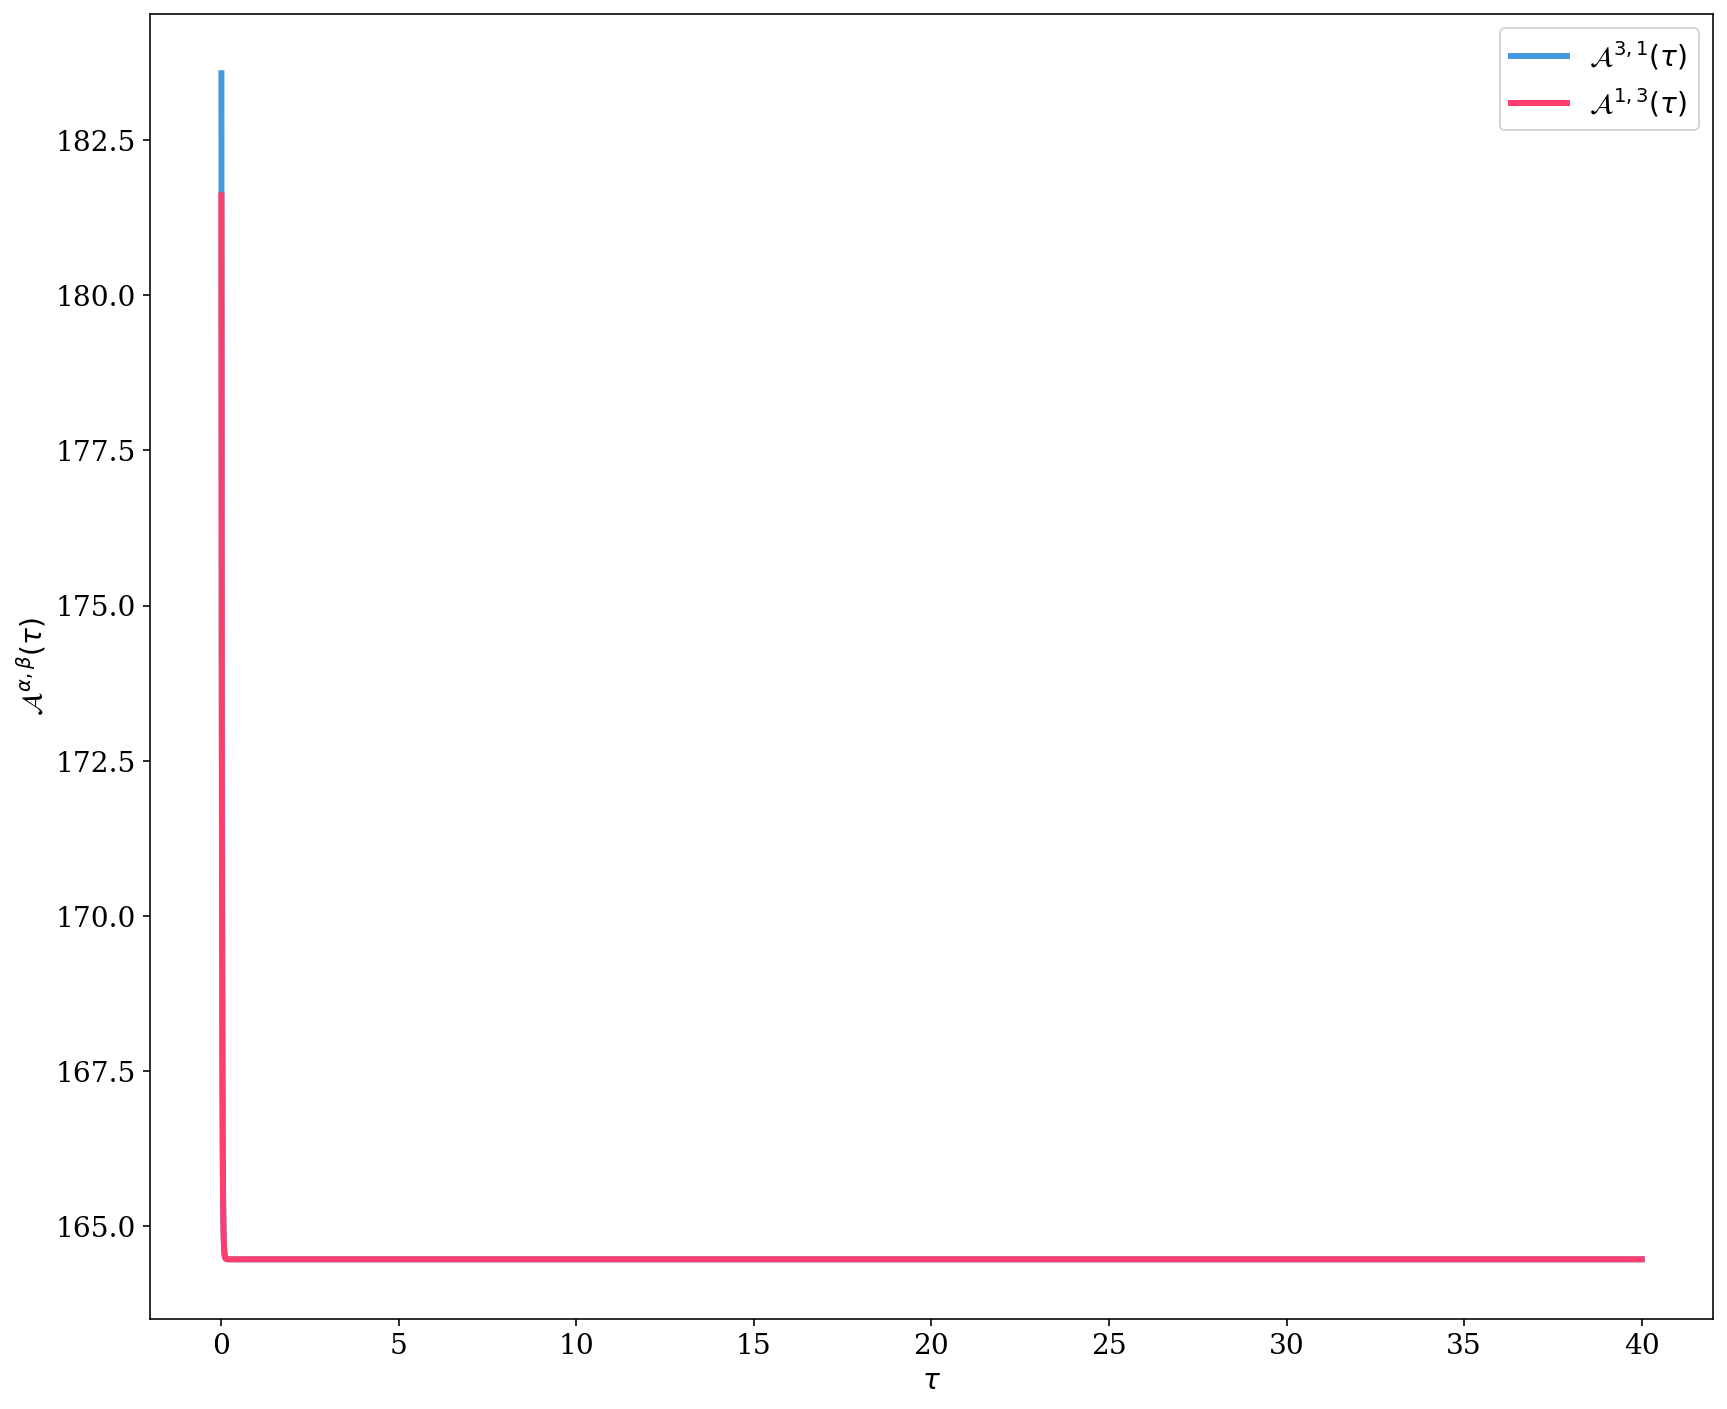

In [40]:
fig = plt.figure()
plt.plot(tau,a_13,label=r'$\mathcal{A}^{3,1}(\tau)$',linewidth=3, c= '#4599DF')
plt.plot(tau,a_31,label=r'$\mathcal{A}^{1,3}(\tau)$',linewidth=3,color='#FF3D6E')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathcal{A}^{\alpha,\beta}(\tau)$")
plt.legend()
plt.show()

In [55]:
# choosing a tau range large enough such that the entire decay is captured for as many sets of autocorrelation functions as possible
tau = np.around(np.arange(0.01,40.0,step=.01), decimals = 2)
signal = [3, 5, 7]
alpha = 1
beta = 3

count = 0
issues = 0
a13_over = 0
a31_over = 0

# over 100 non-equilibrium parameter sets on K
for i in tqdm(range(10000)):
    
    # randomly sample new parameters on K
    params = random_parameters()
    
    # calculate the autocorrelation functions
    L = Laplacian_K(params)
    pi = steady_state_MTT(params)
    a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha,beta)
    
    # for how many values is one autocorrelation function strictly greater than the other
    # rounding to 5 decimal points
    a_13_sum = sum(a_13.round(10) > a_31.round(10))
    a_31_sum = sum(a_31.round(10) > a_13.round(10))
    
    # if either a_31 or a_13 is always less than the other autocorrelation function
    if (a_31_sum == 0) or (a_13_sum == 0):
        count += 1
        
        # which autocorrelation function lies on top of the other
        if a_31_sum == 0:
            a13_over += 1
        if a_13_sum == 0:
            a31_over += 1
    
    else: 
        issues += 1

100%|███████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


In [56]:
count

82

In [57]:
a13_over

43

In [58]:
a31_over

39

In [59]:
issues

18

What I should do: ask if the issues are really instances where one function crosses the other? If not, then they can be included in count.